In [1]:
import pandas as pd
import numpy as np
import jieba
import warnings
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import gensim
import pickle as pkl
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']

In [3]:
# 读取数据
comment = pd.read_csv('data/comment2.csv', index_col=None)
comment

,comment,score
0,老婆,1
1,喜欢,1
2,目前 人物形象 塑造 的 最 完美 的 角色,1
3,水龙 水龙 别哭 啦,1
4,。,1
...,...,...
50372,钟 老爷 永远 满分,1
50373,得闲 饮茶 ！,1
50374,固若金汤,1
50375,安全感 ， 璃 月 的 神 ！,1


# 4.基于情感词典分析

## 4.1 根据已有情感词典库进行分析

### 词典整理

In [7]:
# 读取情感词典
# 清华
tsinghua_dict = pd.DataFrame({'word':[],'score':[]})
tsinghua = pd.read_csv('emotion_dict/tsinghua.txt',header=None)
for i in tsinghua[0]:
    tsinghua_dict.loc[len(tsinghua_dict)] = i.split()
# 将得分转化为浮点数
tsinghua_dict['score'] = tsinghua_dict['score'].astype(float)

# 台湾大学
ntusd_positive = pd.read_csv('emotion_dict/ntusd_positive.txt',header=None)
ntusd_negative = pd.read_csv('emotion_dict/ntusd_negative.txt',header=None)
ntusd_positive['score']  = 1
ntusd_negative['score']  = -1
ntusd_dict = pd.concat([ntusd_positive,ntusd_negative])
ntusd_dict.columns = ['word', 'score']
ntusd_dict = ntusd_dict.drop_duplicates().reset_index()[['word','score']]

# 读取程度词典
degree_extreme = pd.read_csv('emotion_dict/degree_extreme.txt',header=None)
degree_extreme['score'] = 2
degree_very = pd.read_csv('emotion_dict/degree_very.txt',header=None)
degree_very['score'] = 1.5
degree_more = pd.read_csv('emotion_dict/degree_more.txt',header=None)
degree_more['score'] = 1.2
degree_slight = pd.read_csv('emotion_dict/degree_slight.txt',header=None)
degree_slight['score'] = 0.5
degree_defect = pd.read_csv('emotion_dict/degree_defect.txt',header=None)
degree_defect['score'] = -1

# 将程度词典合并成一张表
emotion_degree = pd.concat([degree_extreme,degree_very,degree_more,degree_slight,degree_defect])
emotion_degree = emotion_degree.drop_duplicates().reset_index()[[0,'score']]
emotion_degree.columns = ['word','score']

# 大连理工
dltu = pd.read_excel('emotion_dict/DLTU.xlsx')
PA = dltu[dltu['情感分类'] == 'PA']
PB = dltu[dltu['情感分类'] == 'PB']
PC = dltu[dltu['情感分类'] == 'PC']
PD = dltu[dltu['情感分类'] == 'PD']
PE = dltu[dltu['情感分类'] == 'PE']
PF = dltu[dltu['情感分类'] == 'PF']
PG = dltu[dltu['情感分类'] == 'PG']
PH = dltu[dltu['情感分类'] == 'PH']
dltu_positive = pd.concat([PA,PB,PC,PD,PE,PF,PH])
dltu_positive = pd.DataFrame(dltu_positive['词语'])
NA = dltu[dltu['情感分类'] == 'NA']
NB = dltu[dltu['情感分类'] == 'NB']
NC = dltu[dltu['情感分类'] == 'NC']
ND = dltu[dltu['情感分类'] == 'ND']
NE = dltu[dltu['情感分类'] == 'NE']
NF = dltu[dltu['情感分类'] == 'NF']
NG = dltu[dltu['情感分类'] == 'NG']
NH = dltu[dltu['情感分类'] == 'NH']
NI = dltu[dltu['情感分类'] == 'NH']
NJ = dltu[dltu['情感分类'] == 'NH']
NK = dltu[dltu['情感分类'] == 'NH']
NL = dltu[dltu['情感分类'] == 'NH']
dltu_negative = pd.concat([NA,NB,NC,ND,NE,NF,NH,NI,NJ,NK,NL])
dltu_negative = pd.DataFrame(dltu_negative['词语'])

dltu_positive['score'] = 1
dltu_negative['score'] = -1
dltu_dict = pd.concat([dltu_positive,dltu_negative])
dltu_dict = dltu_dict.drop_duplicates().reset_index()[['词语','score']]
dltu_dict.columns = ['word','score']

# Bosonnlp
bosonnlp_dict = pd.read_csv('emotion_dict/BosonNLP.txt',sep=' ',header=None)
bosonnlp_dict.columns = ['word','score']

In [8]:
# 将数据框形式转换为词典形式
def df_to_dict(dict_df):
    dict_dict = {}
    for i in range(len(dict_df)):
        dict_dict[dict_df['word'][i]] = dict_df['score'][i]
    return dict_dict

bosonnlp_dict = df_to_dict(bosonnlp_dict)
tsinghua_dict = df_to_dict(tsinghua_dict)
ntusd_dict = df_to_dict(ntusd_dict)
dltu_dict = df_to_dict(dltu_dict)
degree_dict = df_to_dict(emotion_degree)

In [9]:
# 情感词典分析
def sensation_analyse(text,emotion_dict,emotion_degree_dict=''):
    '''情感分析（考虑程度词）'''
    words = text.split()
    emotion_score = 0
    # 考虑程度词
    for i, word in enumerate(words):
        score = 0
        if word in emotion_dict.keys():
            score = emotion_dict[word]
            if words[i-1] in emotion_degree_dict.keys():
                degree = emotion_degree_dict[words[i-1]]
                score = score * degree
        emotion_score += score
    return emotion_score/(len(words)+1)

# 获取评论情感极性得分
def get_comment_score(comment_data,emotion_dict,emotion_degree_dict=''):
    analyse_score = []
    for comment in comment_data['comment']:
        emotion_score = sensation_analyse(comment,emotion_dict,emotion_degree_dict)
        if emotion_score < 0:
            emotion_score = 0
        elif emotion_score >= 0:
            emotion_score = 1
        analyse_score.append(emotion_score)
    return analyse_score

### 评论得分预测

In [11]:
result_bosonnlp = get_comment_score(comment, bosonnlp_dict, degree_dict)
result_tsinghua = get_comment_score(comment, tsinghua_dict, degree_dict)
result_ntusd = get_comment_score(comment, ntusd_dict, degree_dict)
result_dltu = get_comment_score(comment, dltu_dict, degree_dict)

### 性能度量

In [40]:
# 模型的性能度量
def performance_test(name,y_test,y_pred):
    # 准确度
    accuracy = accuracy_score(y_test, y_pred)
    # 精确度
    precision = precision_score(y_test, y_pred) 
    # 召回率
    recall = recall_score(y_test, y_pred)
    # F1分数
    f1 = f1_score(y_test, y_pred)
    # AUC值
    roc_auc = roc_auc_score(y_test, y_pred)
    result = {'model':[name],'accuracy':[accuracy],'precision':[precision],
              'recall':[recall],'f1':[f1],'auc':roc_auc}
    result = pd.DataFrame(result)  # 字典转dataframe
    return result

In [61]:
# 结果合并
bosonnlp_pfms = performance_test('bosonnlp_dict', comment['score'], result_bosonnlp)
dltu_pfms = performance_test('dltu_dict', comment['score'], result_dltu)
tsinghua_pfms = performance_test('tsinghua_dict', comment['score'], result_tsinghua)
ntusd_pfms = performance_test('ntusd_dict', comment['score'], result_ntusd)
pfms = pd.concat([bosonnlp_pfms, dltu_pfms, tsinghua_pfms, ntusd_pfms])
pfms

,model,accuracy,precision,recall,f1,auc
0,bosonnlp_dict,0.652222,0.740794,0.745241,0.743011,0.602305
0,dltu_dict,0.678782,0.685785,0.966838,0.802413,0.524201
0,tsinghua_dict,0.659706,0.695075,0.882890,0.777805,0.539938
0,ntusd_dict,0.684777,0.712365,0.893512,0.792722,0.572763


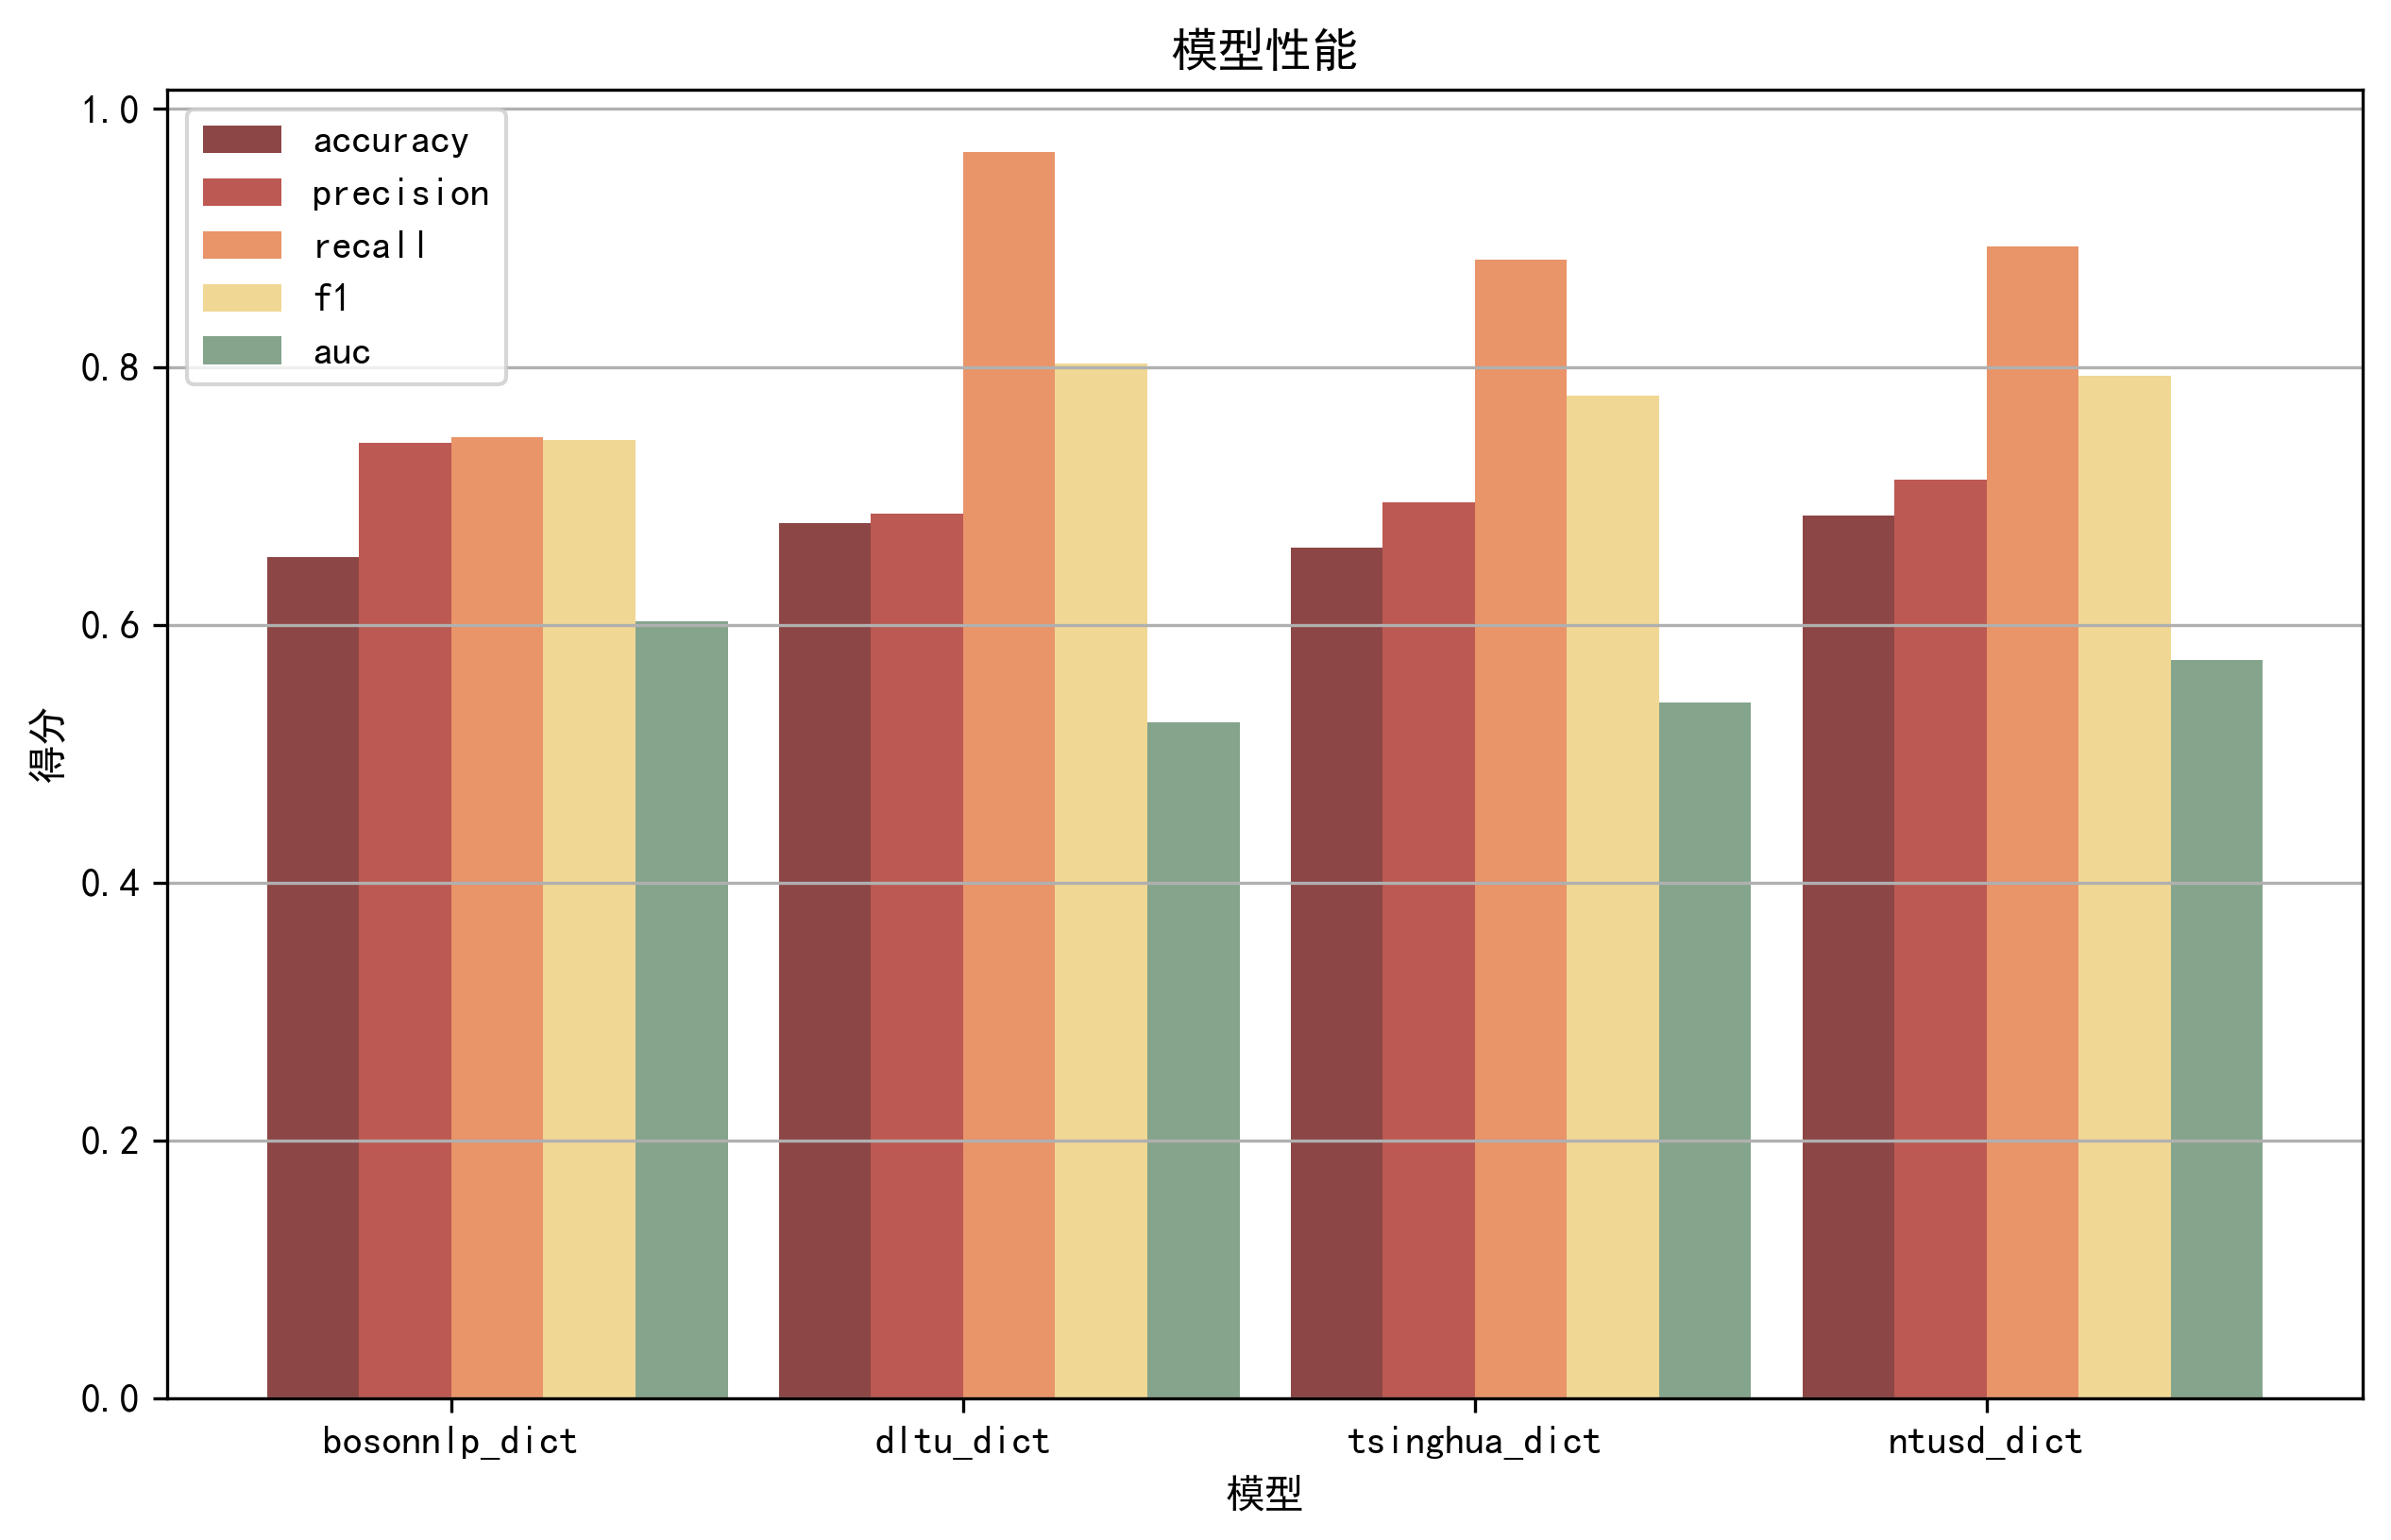

In [63]:
# 模型性能绘图
plt.figure(figsize=(10,6),dpi=300)
categories = ['bosonnlp_dict', 'dltu_dict', 'tsinghua_dict', 'ntusd_dict']
bar_width = 0.18
index = np.arange(len(categories))

plt.bar(index - bar_width, pfms['accuracy'].values, bar_width, label='accuracy',color='#8c4646')
plt.bar(index, pfms['precision'].values, bar_width, label='precision',color='#bc5952')
plt.bar(index + bar_width, pfms['recall'].values, bar_width, label='recall',color='#e99469')
plt.bar(index + bar_width*2, pfms['f1'].values, bar_width, label='f1',color='#f0d794')
plt.bar(index + bar_width*3, pfms['auc'].values, bar_width, label='auc',color='#85a48c')

plt.title('模型性能')
plt.ylabel('得分')
plt.xlabel('模型')
plt.grid(axis='y')
plt.xticks(index + bar_width / 2, categories)
plt.legend()
plt.savefig('result/模型性能.png')
plt.show()

In [65]:
pfms.to_csv('data/result_dict.csv',index=None)